El objetivo de el trabajo es descubrir si hay una releación entre el precio del GNC y el precio de los materiales de construcción en Rosario. La hipótesis es que a medida que aumente el precio del GNC aumentaran los gastos de transporte por lo que también aumentaran los precios de los materiales.

Para analizar esto se tomaron datos desde enero de 2019 hasta abril del 2023.

# Exploración de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

Los datasets se obutiveron de las siguientes fuentes:
- [Precios gas natural](http://datos.energia.gob.ar/dataset/precios-de-gas-natural)
- [Precios materiales](https://datosabiertos.rosario.gob.ar/dataset/%C3%ADndices-de-precios-de-materiales-de-la-construcci%C3%B3n)

In [2]:
precios_gas        = pd.read_csv('datasets/precios-gas-natural.csv')
precios_materiales = pd.read_csv('datasets/precios-materiales-construccion.csv')

In [3]:
precios_materiales.rename(
    columns={
        'Año': 'anio',
        'Mes': 'mes',
        'id_Rubro': 'id_rubro',
        'Rubro': 'rubro',
        'variación mensual': 'variacion_mensual'
    },
    inplace=True
)   

Solo se van a analizar el total de los precios, sin importar el tipo de contrato

In [4]:
precios_gas = \
    precios_gas[precios_gas.contrato == 'TOTAL']

Se separa por cuenca.

In [5]:
santa_cruz = precios_gas[precios_gas.cuenca == 'Austral Santa Cruz']
santa_cruz.Name = 'Austral Santa Cruz'

tierra_del_fuego = precios_gas[precios_gas.cuenca == 'Austral Tierra del Fuego']
tierra_del_fuego.Name = 'Austral Tierra del Fuego'

golfo_san_jorge = precios_gas[precios_gas.cuenca == 'Golfo de San Jorge']
golfo_san_jorge.Name = 'Golfo de San Jorge'

neuquina = precios_gas[precios_gas.cuenca == 'Neuquina']
neuquina.Name = 'Neuquina'

noroeste = precios_gas[precios_gas.cuenca == 'Noroeste']
noroeste.Name = 'Noroeste'

cuencas = [
    santa_cruz, tierra_del_fuego,
    golfo_san_jorge, neuquina,
    noroeste
]

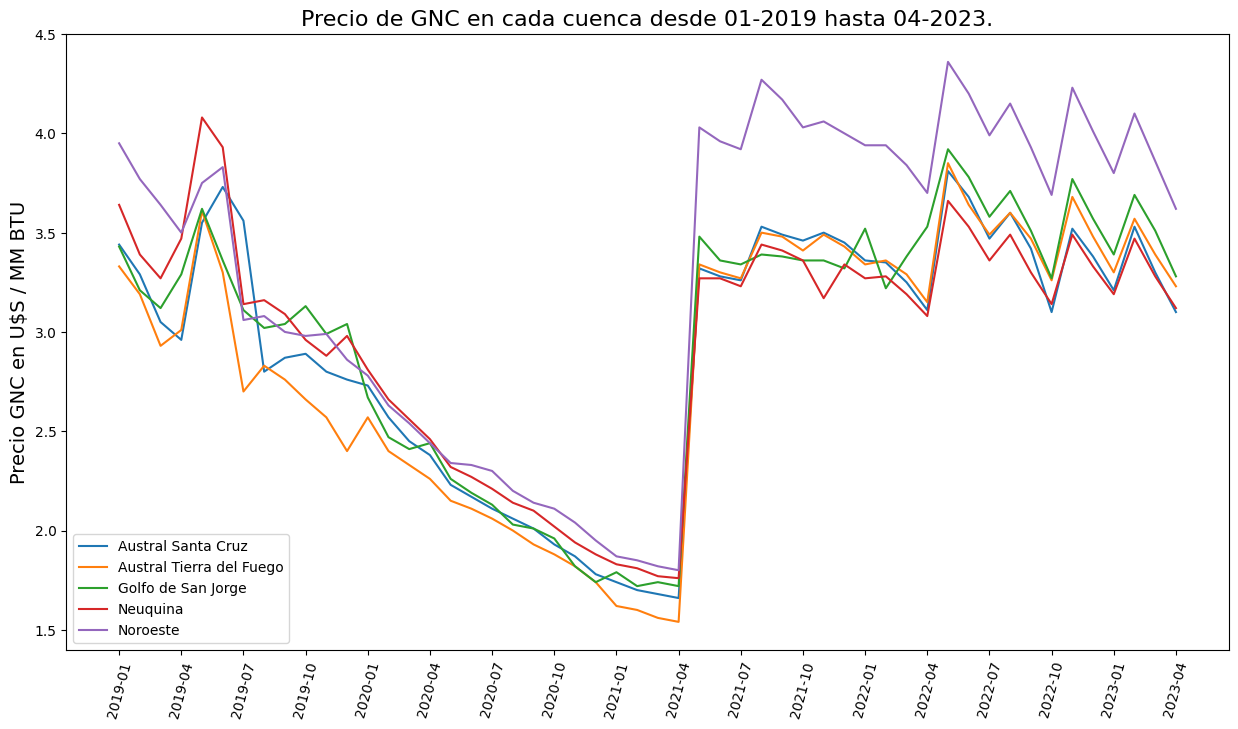

In [6]:
plt.figure(figsize=(15, 8))

for cuenca in cuencas:
    plt.plot(
        cuenca.indice_tiempo,
        cuenca.precio_gnc,
        label=cuenca.Name
    )

plt.xticks(np.arange(0, 52, 3), rotation=75)
plt.title(
    'Precio de GNC en cada cuenca desde 01-2019 hasta 04-2023.',
    fontsize=16
)

plt.ylabel(
    'Precio GNC en U$S / MM BTU',
    fontsize=14
)

plt.legend()

In [7]:
exportaciones_promedio = []

for cuenca in cuencas:
    exportaciones_promedio.append(
        (
            cuenca.Name,
            round(cuenca.precio_expo.mean(), 2)
        )
    )
    
exportaciones_promedio.sort(key=lambda tupla: tupla[1], reverse=True)

Precio promedio para la exportación de cada cuenca:

In [8]:
for val in exportaciones_promedio:
    print(f'{val[0]:<25} {val[1]}')

Neuquina                  4.59
Austral Santa Cruz        2.52
Austral Tierra del Fuego  1.56
Golfo de San Jorge        0.88
Noroeste                  0.14


Naturalmente la cuenca Neuquina tiene el mayor precio para las exportación ya que ahí se encuentra Vaca Muerta.

Text(0.5, 1.0, 'Relación entre el precio de GNC y el precio de exportación')

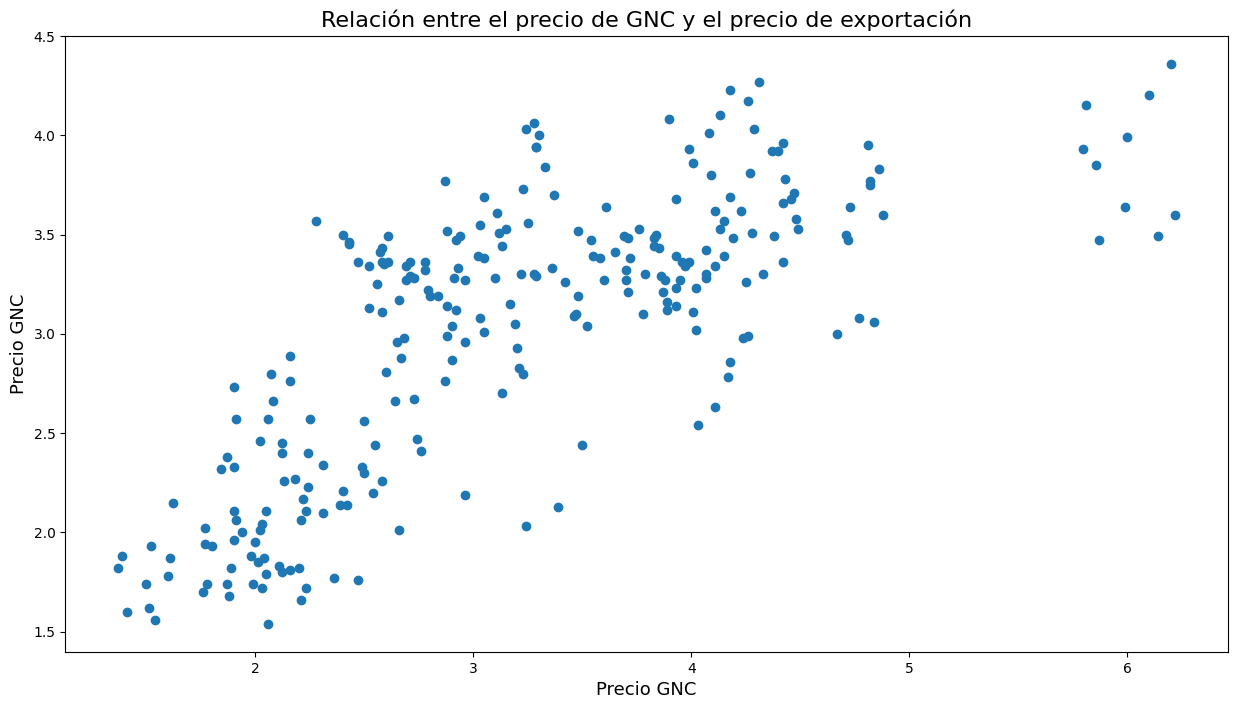

In [76]:
plt.figure(figsize=(15, 8))

cuencas_total = \
    precios_gas[(precios_gas.contrato == 'TOTAL') & (precios_gas.cuenca != 'Total Cuenca')]

plt.scatter(cuencas_total.precio_industria,
            cuencas_total.precio_gnc)

plt.xlabel(
    'Precio GNC',
    fontsize=13
)

plt.ylabel(
    'Precio GNC',
    fontsize=13
)

plt.title(
    'Relación entre el precio de GNC y el precio de exportación',
    fontsize=16
)

Podemos ver en el gráfico que hay una correlación entre el precio de GNC y el precio de venta a la industria. Tiene sentido que esto sea así porque ademas de los gastos de industria las empresas también tienen los gastos de transporte para la logística.

In [10]:
precios_materiales.anio = precios_materiales.anio.astype(str)
precios_materiales.mes = precios_materiales.mes.astype(str)

Calculamos cuál fue el porcentaje de aumento del precio de cada material desde 2019 hasta 2023.

In [11]:
precios_materiales['indice_tiempo'] = \
    precios_materiales.anio + '-' + precios_materiales.mes.str.zfill(2)

In [12]:
id_rubros = precios_materiales.id_rubro.unique()

In [13]:
porcentajes = list()

for rubro in id_rubros:
    precio_inicial = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].indice
    
    precio_final = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[-1].indice
    
    nombre_material = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].rubro
    
    rango = precio_final - precio_inicial
    
    porcentajes.append((nombre_material, round((rango / precio_inicial) * 100, 2)))

In [14]:
porcentajes.sort(key=lambda tupla: tupla[1])

Text(0, 0.5, 'Aumento de precio en %')

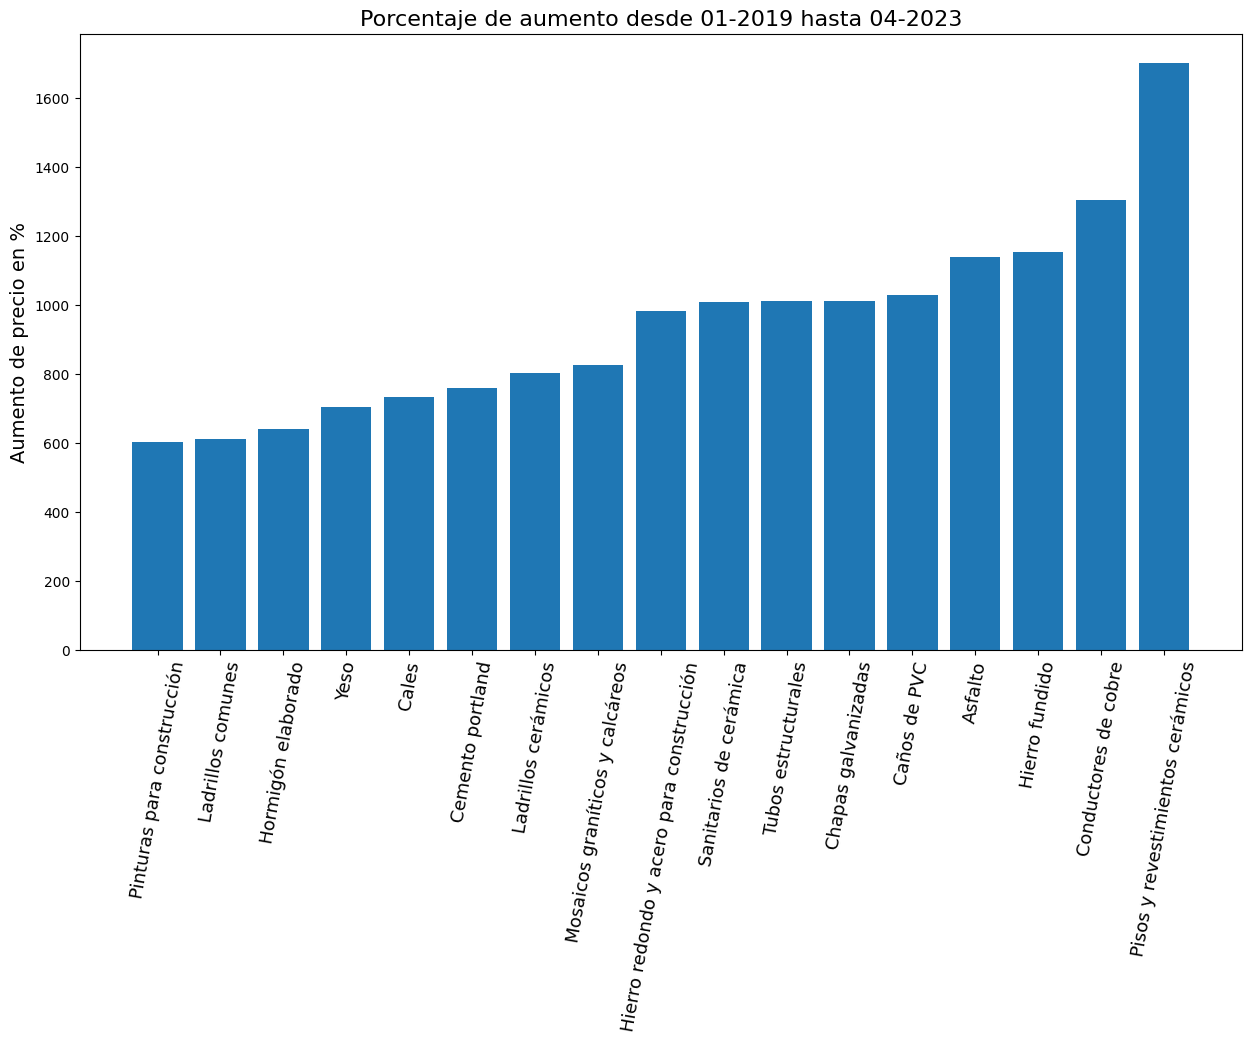

In [15]:
plt.figure(figsize=(15, 8))

plt.bar(
    [tupla[0] for tupla in porcentajes],
    [tupla[1] for tupla in porcentajes]
)

plt.xticks(
    rotation=80,
    fontsize=13
)

plt.title(
    'Porcentaje de aumento desde 01-2019 hasta 04-2023',
    fontsize=16
)

plt.ylabel('Aumento de precio en %', fontsize=14)

Es interesante ver que los pisos y revestimientos cerámicos tuvieron el aumento más grande de todos. Las otras categorías también tuvieron un gran aumento pero no hay un salto tan grande entre estos materiales. Esto se deba a que probablemente los pisos y revestimientos sea caros de fabricar y no tengan tanta demanda como otros tipos de materiales más esenciales.

<Axes: >

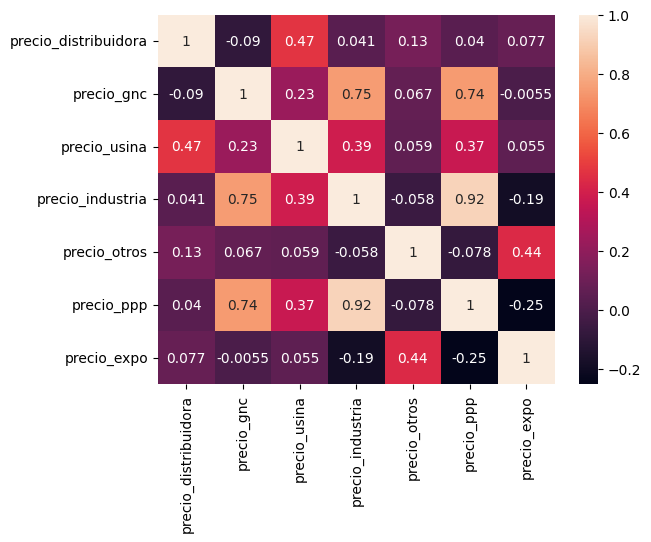

In [16]:
sns.heatmap(
    cuencas_total[[
        columna for columna
        in cuencas_total.columns
        if columna.startswith('precio_')
    ]].corr(), annot=True
)

Se puede observar una fuerte relación entre el precio para el sector GNC y el precio para el sector industrial y también entre el precio del sector GNC y el precio promedio ponderado (PPP). 

Text(0.5, 1.0, 'Distribución de los precios para los distintos sectores')

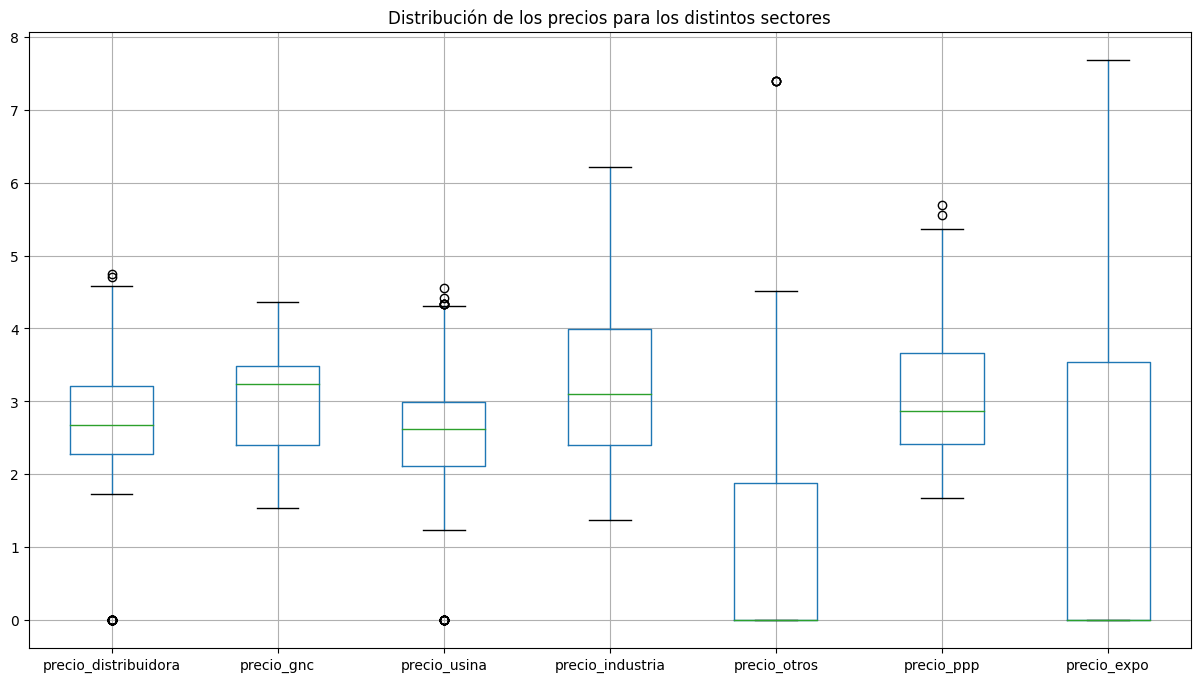

In [17]:
plt.figure(figsize=(15, 8))

cuencas_total.boxplot(
    column=[
        columna for columna
        in cuencas_total.columns
        if columna.startswith('precio_')
    ]
)

plt.title('Distribución de los precios para los distintos sectores')

## Dispersión de los datos

Para ver como se comportan las variables de intéres usamos algunas medidas de resumen y dispersión.

In [18]:
cuencas_total[
    ['anio', 'mes', 'cuenca', 'precio_gnc', 'precio_industria']]\
    .groupby(['anio', 'cuenca'])\
    .describe()['precio_gnc']

# Precio GNC

count      mean       std   min     25%    50%  \
anio cuenca                                                                     
2019 Austral Santa Cruz         12.0  3.141667  0.351176  2.76  2.8525  3.005   
     Austral Tierra del Fuego   12.0  2.940833  0.357655  2.40  2.6900  2.880   
     Golfo de San Jorge         12.0  3.196667  0.193077  2.99  3.0400  3.125   
     Neuquina                   12.0  3.332500  0.384923  2.88  3.0625  3.215   
     Noroeste                   12.0  3.367500  0.406294  2.86  2.9975  3.290   
2020 Austral Santa Cruz         12.0  2.190833  0.291624  1.78  1.9900  2.140   
     Austral Tierra del Fuego   12.0  2.104167  0.250217  1.74  1.9175  2.085   
     Golfo de San Jorge         12.0  2.177500  0.282300  1.74  1.9975  2.160   
     Neuquina                   12.0  2.280833  0.291998  1.88  2.0800  2.240   
     Noroeste                   12.0  2.316667  0.248169  1.95  2.1325  2.315   
2021 Austral Santa Cruz         12.0  2.839167  0.849529  1.66  1.7300  3.300   
     Austral Tierra del Fuego   12.0  2.795000  0.900369  1.54  1.6150  3.320   
     Golfo de San Jorge         12.0  2.830000  0.804273  1.72  1.7775  3.350   
     Neuquina                   12.0  2.805000  0.751586  1.76  1.8250  3.250   
     Noroeste                   12.0  3.315000  1.096950  1.80  1.8650  3.980   
2022 Austral Santa Cruz         12.0  3.420833  0.213646  3.10  3.3250  3.400   
     Austral Tierra del Fuego   12.0  3.467500  0.200596  3.15  3.3275  3.475   
     Golfo de San Jorge         12.0  3.563333  0.209342  3.22  3.4775  3.550   
     Neuquina                   12.0  3.343333  0.171641  3.08  3.2500  3.315   
     Noroeste                   12.0  3.998333  0.206478  3.69  3.9075  3.965   
2023 Austral Santa Cruz          4.0  3.285000  0.182665  3.10  3.1825  3.255   
     Austral Tierra del Fuego    4.0  3.372500  0.147054  3.23  3.2825  3.345   
     Golfo de San Jorge          4.0  3.467500  0.175570  3.28  3.3625  3.450   
     Neuquina                    4.0  3.265000  0.151548  3.12  3.1725  3.235   
     Noroeste                    4.0  3.845000  0.198242  3.62  3.7550  3.830   

                                  75%   max  
anio cuenca                                  
2019 Austral Santa Cruz        3.4675  3.73  
     Austral Tierra del Fuego  3.2175  3.61  
     Golfo de San Jorge        3.3075  3.62  
     Neuquina                  3.5125  4.08  
     Noroeste                  3.7550  3.95  
2020 Austral Santa Cruz        2.3975  2.73  
     Austral Tierra del Fuego  2.2775  2.57  
     Golfo de San Jorge        2.4175  2.67  
     Neuquina                  2.4850  2.81  
     Noroeste                  2.4650  2.78  
2021 Austral Santa Cruz        3.4675  3.53  
     Austral Tierra del Fuego  3.4425  3.50  
     Golfo de San Jorge        3.3650  3.48  
     Neuquina                  3.3450  3.44  
     Noroeste                  4.0375  4.27  
2022 Austral Santa Cruz        3.5400  3.81  
     Austral Tierra del Fuego  3.6100  3.85  
     Golfo de San Jorge        3.7250  3.92  
     Neuquina                  3.4900  3.66  
     Noroeste                  4.1625  4.36  
2023 Austral Santa Cruz        3.3575  3.53  
     Austral Tierra del Fuego  3.4350  3.57  
     Golfo de San Jorge        3.5550  3.69  
     Neuquina                  3.3275  3.47  
     Noroeste                  3.9200  4.10

In [19]:
cuencas_total[
    ['anio', 'mes', 'cuenca', 'precio_gnc', 'precio_industria']]\
    .groupby(['anio', 'cuenca'])\
    .describe()['precio_industria']

# Precio industria

count      mean       std   min     25%    50%  \
anio cuenca                                                                     
2019 Austral Santa Cruz         12.0  2.883333  0.470074  2.07  2.7150  3.080   
     Austral Tierra del Fuego   12.0  2.933333  0.474252  2.08  2.7150  3.120   
     Golfo de San Jorge         12.0  3.628333  0.552035  2.52  3.3650  3.865   
     Neuquina                   12.0  3.455833  0.506798  2.65  3.2650  3.575   
     Noroeste                   12.0  4.642500  0.257404  4.18  4.5675  4.750   
2020 Austral Santa Cruz         12.0  1.954167  0.264591  1.52  1.8050  1.965   
     Austral Tierra del Fuego   12.0  1.803333  0.270667  1.37  1.5900  1.900   
     Golfo de San Jorge         12.0  2.605833  0.500771  1.87  2.3875  2.695   
     Neuquina                   12.0  2.202500  0.319748  1.77  1.9450  2.245   
     Noroeste                   12.0  2.843333  0.854436  2.00  2.2450  2.495   
2021 Austral Santa Cruz         12.0  2.894167  0.987664  1.76  2.1275  2.430   
     Austral Tierra del Fuego   12.0  2.822500  1.051122  1.41  1.9300  2.595   
     Golfo de San Jorge         12.0  3.000000  0.835486  1.99  2.1850  2.780   
     Neuquina                   12.0  3.007500  0.735121  2.11  2.4425  2.675   
     Noroeste                   12.0  3.322500  1.010770  2.01  2.1800  3.290   
2022 Austral Santa Cruz         12.0  3.594167  0.892010  2.47  2.5875  3.530   
     Austral Tierra del Fuego   12.0  4.385833  1.522292  2.52  3.0550  4.060   
     Golfo de San Jorge         12.0  3.500833  0.826927  2.28  2.8775  3.100   
     Neuquina                   12.0  3.503333  0.804469  2.69  2.8600  2.985   
     Noroeste                   12.0  4.635833  1.237295  3.29  3.3600  4.180   
2023 Austral Santa Cruz          4.0  3.760000  0.035590  3.71  3.7475  3.770   
     Austral Tierra del Fuego    4.0  3.900000  0.417852  3.28  3.8350  4.085   
     Golfo de San Jorge          4.0  3.072500  0.045735  3.02  3.0425  3.075   
     Neuquina                    4.0  2.897500  0.038622  2.84  2.8925  2.915   
     Noroeste                    4.0  4.085000  0.052599  4.01  4.0700  4.100   

                                  75%   max  
anio cuenca                                  
2019 Austral Santa Cruz        3.2300  3.29  
     Austral Tierra del Fuego  3.2125  3.48  
     Golfo de San Jorge        3.9950  4.23  
     Neuquina                  3.8925  3.99  
     Noroeste                  4.8200  4.86  
2020 Austral Santa Cruz        2.2125  2.24  
     Austral Tierra del Fuego  1.9700  2.13  
     Golfo de San Jorge        2.8100  3.39  
     Neuquina                  2.4400  2.64  
     Noroeste                  3.6325  4.17  
2021 Austral Santa Cruz        3.7925  4.25  
     Austral Tierra del Fuego  3.8500  4.07  
     Golfo de San Jorge        3.7725  4.11  
     Neuquina                  3.7325  3.95  
     Noroeste                  4.2950  4.42  
2022 Austral Santa Cruz        4.3175  4.88  
     Austral Tierra del Fuego  5.9000  6.22  
     Golfo de San Jorge        4.3850  4.48  
     Neuquina                  4.3900  4.49  
     Noroeste                  5.8575  6.20  
2023 Austral Santa Cruz        3.7825  3.79  
     Austral Tierra del Fuego  4.1500  4.15  
     Golfo de San Jorge        3.1050  3.12  
     Neuquina                  2.9200  2.92  
     Noroeste                  4.1150  4.13

In [20]:
cuencas_total

,id_pub,anio,mes,cuenca,contrato,precio_distribuidora,precio_gnc,precio_usina,precio_industria,precio_otros,precio_ppp,precio_expo,indice_tiempo
2,3,2019,1,Austral Santa Cruz,TOTAL,3.40,3.44,2.65,3.13,3.75,3.03,3.08,2019-01
5,6,2019,1,Austral Tierra del Fuego,TOTAL,3.66,3.33,2.81,3.36,0.00,3.19,3.49,2019-01
8,9,2019,1,Golfo de San Jorge,TOTAL,4.75,3.43,2.87,3.85,0.00,3.79,5.22,2019-01
11,12,2019,1,Neuquina,TOTAL,3.84,3.64,2.98,3.61,3.63,3.36,4.25,2019-01
14,15,2019,1,Noroeste,TOTAL,3.83,3.95,3.29,4.81,0.00,4.25,0.00,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,921,2023,4,Austral Santa Cruz,TOTAL,2.61,3.10,4.14,3.78,0.00,3.66,3.59,2023-04
923,924,2023,4,Austral Tierra del Fuego,TOTAL,2.52,3.23,2.65,4.02,0.00,2.85,0.00,2023-04
926,927,2023,4,Golfo de San Jorge,TOTAL,2.85,3.28,4.03,3.10,0.00,3.36,0.00,2023-04
929,930,2023,4,Neuquina,TOTAL,2.32,3.12,2.66,2.92,7.40,2.74,7.57,2023-04


## Unión de los datasets

Los datos solo se unen con la cuenca Neuquina porque de las disponibles en el dataset es la más cercana geograficamente a Rosario, así que es muy probable que los distribuidores de GNC de la ciudad compren el gas natural de esta cuenca.

In [21]:
precios = \
    pd.merge(
        left=neuquina,
        right=precios_materiales,
        how='inner',
        left_on='indice_tiempo',
        right_on='indice_tiempo'
    )

In [22]:
precios.drop(
    columns={
        'anio_x',
        'mes_x',
        'anio_y',
        'mes_y'
    },
    inplace=True
)

Vamos a comparar el precio del GNC con dos materiales, el que más aumento de precio (`id_rubro = 14`) y el que menos aumentó (`id_rubro = 13`).

In [26]:
precios_ceramicos = precios[precios.id_rubro == 14]
precios_pinturas  = precios[precios.id_rubro == 13]

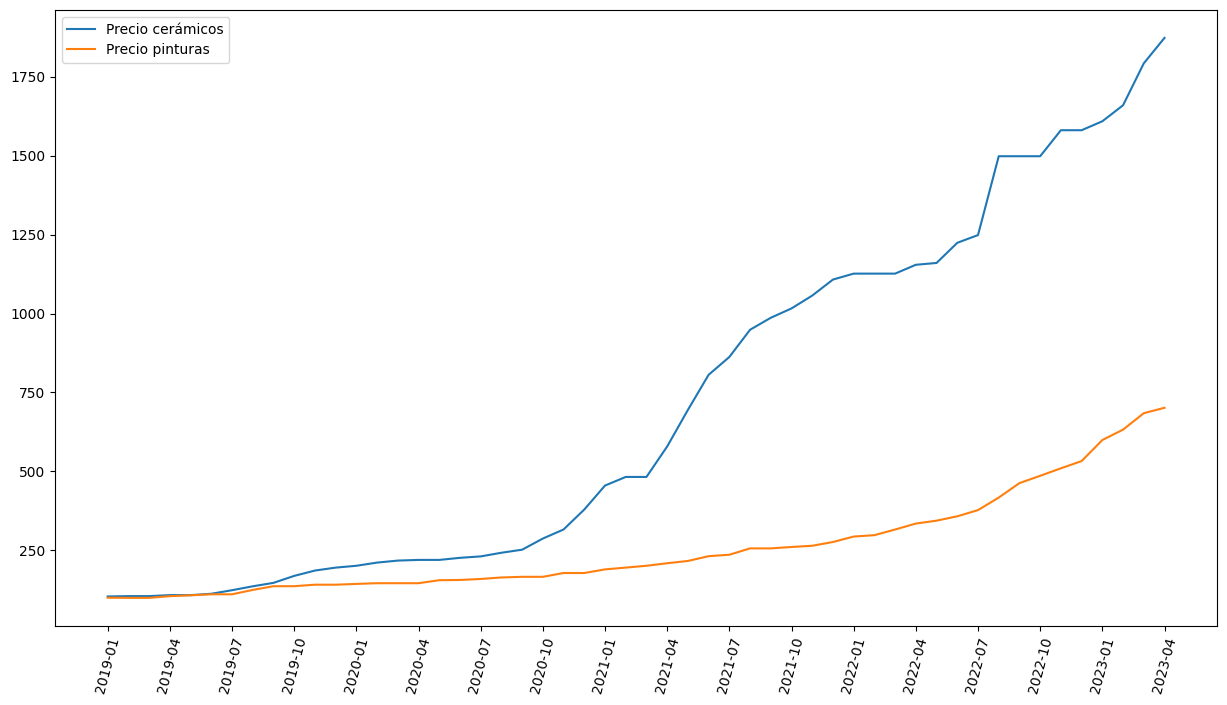

In [27]:
plt.figure(figsize=(15, 8))

plt.plot(
    precios_ceramicos.indice_tiempo,
    precios_ceramicos.indice,
    label='Precio cerámicos'
)

plt.plot(
    precios_pinturas.indice_tiempo,
    precios_pinturas.indice,
    label='Precio pinturas'
)

plt.xticks(np.arange(0, 52, 3), rotation=75)

plt.legend()

Ambos materiales tienen una tendencia creciente en estos últimos cuatro años. Sin embargo a partir de abril de 2021 el precio de los cerámicos comenzó a aumentar su precio a un nivel más rápido, esto coincide con el aumento significativo que tuvo el precio de venta del GNC.

Estos podría relacionarse a que es usual que las placas para los pisos y revestimienos cerámicos suelen romperse durante el transporte, por esto en general se envían y se producen de más para reemplazar los defectuosos. Esto no ocurre en el caso de la pintura que está bien protegida y no tiene problemas durante su transporte.

In [28]:
precios_materiales.head(20)

,anio,mes,id_rubro,rubro,indice,variacion_mensual,indice_tiempo
0,2019,1,1,Asfalto,100.000000,0.000000,2019-01
1,2019,1,2,Cales,100.995049,0.995049,2019-01
2,2019,1,4,Cemento portland,102.000000,2.000000,2019-01
3,2019,1,8,Hierro redondo y acero para construcción,100.000000,0.000000,2019-01
4,2019,1,9,Hormigón elaborado,102.000000,2.000000,2019-01
5,2019,1,10,Ladrillos cerámicos,100.000000,0.000000,2019-01
6,2019,1,11,Ladrillos comunes,98.000000,-2.000000,2019-01
7,2019,1,12,Mosaicos graníticos y calcáreos,100.000000,0.000000,2019-01
8,2019,1,13,Pinturas para construcción,100.000000,0.000000,2019-01
9,2019,1,14,Pisos y revestimientos cerámicos,104.000000,4.000000,2019-01


# Regresión lineal

In [82]:
mod_cuencas = smf.ols(formula='precio_gnc ~ precio_industria', data=cuencas_total)
res_cuencas = mod_cuencas.fit()

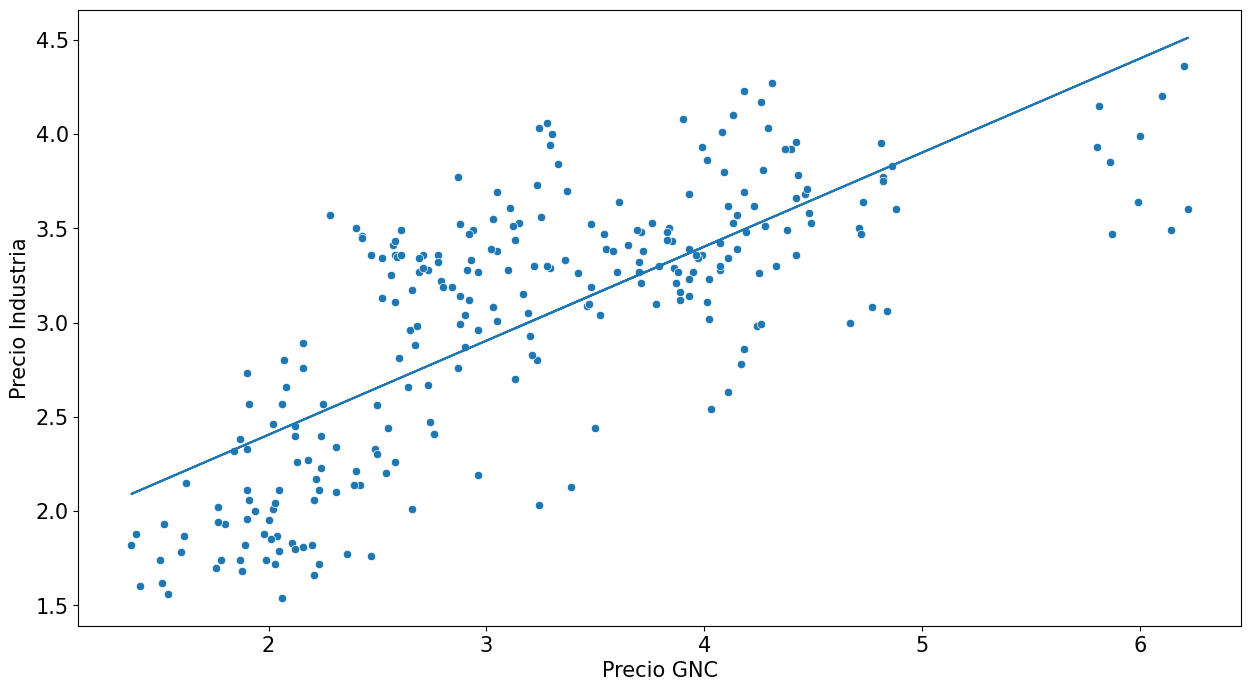

In [84]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='precio_industria', y='precio_gnc', data=cuencas_total)
plt.plot(cuencas_total['precio_industria'], res_cuencas.predict(cuencas_total['precio_industria']))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Precio GNC', fontsize = 15)
plt.ylabel('Precio Industria',fontsize = 15);

## Normalización

Normalizamos las variables con las que vamos a hacer el modelo

In [53]:
datos_normalizados = \
    cuencas_total.drop(
        columns=['id_pub', 'anio', 'mes', 'contrato', 'indice_tiempo']
    ).copy()

In [57]:
for columna in datos_normalizados.drop(columns=['cuenca']):
    datos_normalizados[columna] = (datos_normalizados[columna] - datos_normalizados[columna].mean()) / datos_normalizados[columna].std()

## Variables dummy

In [59]:
nombres_cuencas = [cuenca.Name for cuenca in cuencas]

In [66]:
for cuenca in nombres_cuencas[:-1]:
    datos_normalizados[cuenca.replace(' ', '_').lower()] = 0
    datos_normalizados.loc[
        datos_normalizados['cuenca'] == cuenca, 
        cuenca.replace(' ', '_').lower()] = 1

In [68]:
variables_dummy = ' + '.join(cuenca.replace(' ', '_').lower() for cuenca in nombres_cuencas[:-1])
variables_dummy = ' + ' + variables_dummy

In [69]:
mod_cuencas = smf.ols(
    formula=\
        f'precio_gnc ~ precio_industria + {variables_dummy}',
    data=datos_normalizados)
res_cuencas = mod_cuencas.fit()

In [70]:
print(res_cuencas.summary())

                            OLS Regression Results                            
Dep. Variable:             precio_gnc   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     65.49
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           9.72e-44
Time:                        23:55:04   Log-Likelihood:                -260.75
No. Observations:                 260   AIC:                             533.5
Df Residuals:                     254   BIC:                             554.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Conclusiones